<a href="https://colab.research.google.com/github/ThakdanaiSaelee/Lab_CE888/blob/main/lab6%20-%20recommender/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error

# Libraries for pre-processing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header=None)
df.shape

(24983, 101)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
# replace 99 by Nan because 99 mean 'not rate'
df = df.replace(99, np.nan)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
# Drop first column that in not a rating
df = df.drop(labels = 0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [6]:
# find the best and worst joke using mean value
mean_score = df.mean(axis = 0)
max = -10
max_joke = 0
min = 10
min_joke = 0
for i, v in enumerate(mean_score):
  if v > max:
    max = v
    max_joke = i + 1
  if v < min:
    min = v
    min_joke = i + 1
print('best joke is:',max_joke,'with score:',max,'and worst joke is:',min_joke,'with score',min)

best joke is: 50 with score: 3.6650848950824937 and worst joke is: 58 with score -3.8338796373689923


In [7]:
real_data = df.values

In [13]:
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(~np.isnan(orig))                                                  # rated[0] = row, rated[1] = column
  n_rated = len(rated[0])                                                            # row
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = np.nan
  return new_data, (rated[0][idx], rated[1][idx])

In [14]:
# create New data set 
train_data , index = replace(real_data,0.1)

In [15]:
print(real_data[index[0][1],index[1][1]])

-7.72


In [16]:
print(train_data[index[0][1],index[1][1]])

nan


In [17]:
n_latent_factors = 2

# Initialise as random values
latent_user_preferences = np.random.random((real_data.shape[0], n_latent_factors))
latent_item_features = np.random.random((real_data.shape[1], n_latent_factors))

In [20]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)           # predicting value
    err =  predicted_rating - rating                              # find error
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id] # update new value
    latent_item_features[item_id] -= alpha * err * user_pref_values                 # update new value
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = train_data[user_id, item_id]                    # real rating
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Iteration 0/10:	MSE=24.655692
Iteration 1/10:	MSE=24.445910
Iteration 2/10:	MSE=24.233546
Iteration 3/10:	MSE=24.019069
Iteration 4/10:	MSE=23.803690
Iteration 5/10:	MSE=23.588773
Iteration 6/10:	MSE=23.375709
Iteration 7/10:	MSE=23.165838
Iteration 8/10:	MSE=22.960404
Iteration 9/10:	MSE=22.760505


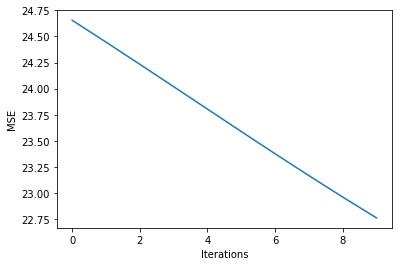

In [21]:
num_iter = 10
hist = sgd(num_iter)

plt.figure()
plt.plot(np.arange(0, num_iter,1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [27]:
# find mse in test data
real_rating = np.zeros(len(index[0]))
pred_rating = np.zeros(len(index[0]))
for i in range(len(index[0])):
  real_rating[i] = real_data[index[0][i],index[1][i]]
  pred_rating[i] = predict_rating(index[0][i],index[1][i])

mse_error = mean_squared_error(real_rating, pred_rating)
print('mse from test set:',mse_error)

mse from test set: 22.880268271588683


In [30]:
real_data[2755, 37]

-9.32

In [31]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.45215946, 1.0303344 , 1.03660015, ..., 1.72517671, 0.75517355,
        2.22030231],
       [1.4833504 , 1.01370397, 1.02229128, ..., 1.72745776, 0.86258229,
        2.26453236],
       [3.15818327, 2.17262429, 2.19009723, ..., 3.69079176, 1.80273155,
        4.82267001],
       ...,
       [0.26981469, 0.17330568, 0.17549297, ..., 0.30427419, 0.18297217,
        0.41091891],
       [0.8730637 , 0.64937215, 0.65145124, ..., 1.06404625, 0.38364125,
        1.33755506],
       [1.24830182, 0.87137118, 0.87756543, ..., 1.47014306, 0.68285508,
        1.90733251]])

In [32]:
values = [zip(real_data[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)

In [33]:
comparison_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,"(-7.82, 1.452159456055828)","(8.79, 1.030334403716969)","(-9.66, 1.0366001467014878)","(-8.16, -0.6053755550783522)","(-7.52, 0.9719330140114655)","(-8.5, 2.4850243298502135)","(-9.85, 0.05527125378955352)","(4.17, -0.3812738615752698)","(-8.98, 0.08106673403903522)","(-4.76, 1.7472620699461334)","(-8.5, 2.610481572802124)","(-6.75, 2.473222662066753)","(-7.18, -1.3428352575686908)","(8.45, 2.414662459557148)","(-7.18, -1.516875948489214)","(-7.52, -2.878774886986302)","(-7.43, -0.6163274669030018)","(-9.81, -0.3540506478766977)","(-9.85, 0.7024069088067111)","(-9.85, -0.2822287611979666)","(-9.37, 3.0846927400953117)","(1.5, 1.7525689645179134)","(-4.37, 0.8929188855233797)","(-9.81, -0.9445941908673773)","(-8.5, 1.3071514338238173)","(1.12, 2.247120195053795)","(7.82, 3.891554261281995)","(2.86, 2.3767915491540967)","(9.13, 3.702255582698095)","(-7.43, 0.5080943122730402)","(2.14, 3.1914599799949324)","(-4.08, 3.8839952180643817)","(-9.08, -0.42188020056426834)","(7.82, 1.828023660917989)","(5.05, 3.7605800673071506)","(4.95, 3.8937413998616783)","(-9.17, -0.6657461774823057)","(-8.4, 1.987325242550366)","(-8.4, 2.109862870010001)","(-8.4, 1.8849064328651175)",...,"(8.59, 3.3733043764871598)","(3.59, 3.7040145259634656)","(-6.84, 1.087576579591525)","(-9.03, 0.07385412213433068)","(2.82, 3.19733973342554)","(-1.36, 3.3254299829516807)","(-9.08, -0.1482822084919905)","(8.3, 3.405819557865683)","(5.68, 3.4670135512442415)","(-4.81, 1.3263639329984953)","(nan, 0.07558872527354144)","(nan, 3.495348331763744)","(nan, 2.0947030183440396)","(nan, -0.48970759510133216)","(nan, 0.5566227116248765)","(nan, 3.169103310709345)","(nan, 1.5976906979610137)","(-9.42, 2.5176293548004693)","(nan, 1.1154917133376807)","(nan, 2.1779754537744647)","(nan, 2.608072452439144)","(-7.72, 1.787544858566127)","(nan, 2.840295508012523)","(nan, 1.51082686640476)","(nan, 1.7469880751541196)","(nan, 0.8600509800375298)","(nan, 2.5782383073575055)","(nan, 2.7141870206817167)","(nan, 4.042984695932815)","(nan, 1.4665174666360399)","(2.82, 2.638044104854788)","(nan, 2.038101392084474)","(nan, 3.188817962974468)","(nan, 1.6389828214622508)","(nan, 1.7186388932839898)","(nan, 2.299382323080186)","(-5.63, 2.2706882611600436)","(nan, 1.7251767107385811)","(nan, 0.7551735491577966)","(nan, 2.220302309876946)"
1,"(4.08, 1.4833504014317498)","(-0.29, 1.0137039725127113)","(6.36, 1.022291281033622)","(4.37, -0.5533849804528935)","(-2.38, 1.0381088386384285)","(-9.66, 2.461186346976139)","(-0.73, 0.1383443354866985)","(-5.34, -0.2932044610141729)","(8.88, 0.14037940165941504)","(9.22, 1.7986682547721176)","(6.75, 2.56664541824834)","(8.64, 2.4779211472768083)","(4.42, -1.312591320936494)","(7.43, 2.4073551490964906)","(4.56, -1.4319197205230048)","(-0.97, -2.737567579963541)","(4.66, -0.5506179161723797)","(-0.68, -0.18914655288058407)","(3.3, 0.78482474427091)","(-1.21, -0.19423649719919)","(0.87, 3.0492694532028666)","(8.64, 1.7342209460511564)","(8.35, 0.8727364430588895)","(9.17, -0.9491474652128229)","(0.05, 1.3235889653938748)","(7.57, 2.3129498765454644)","(4.71, 3.8904174438068075)","(0.87, 2.38233414296145)","(-0.39, 3.6706946888679592)","(6.99, 0.5101988457101984)","(6.5, 3.084003975883484)","(-0.92, 3.8259504937037034)","(7.14, -0.47081080164508454)","(9.03, 1.885717464773542)","(-1.8, 3.7432518952600766)","(0.73, 3.901570101023773)","(7.09, -0.6561837791604099)","(3.4, 2.0003407280852805)","(-0.87, 2.0913636807598106)","(7.91, 1.9278859936026194)",...,"(-6.7, 3.3464511688526586)","(-3.35, 3.705303250976081)","(-9.03, 1.1519176143881509)","(4.47, 0.04376786788402367)","(4.08, 3.192995501069053)","(-3.83, 3.338439340566099)","(8.74, -0.10518120899287396)","(1.12, 3.4050364129292627)","(0.78, 3.437974039388317)","(7.52, 1.38

**Movie dataset**

In [26]:
# load the data
df_movie = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Items',index_col='Movie ID')
df_movie.head()

,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
Movie ID,,,,,,,,,,,,,,,,
11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [35]:
# drop data that not a factor
df_movie_notitle = df_movie.drop(labels = 'Title', axis=1)

In [36]:
df_user = pd.read_excel("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx",sheet_name='Users',index_col='User')
df_user.head()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
User,,,,,,,,,,,,,,,
4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669


In [39]:
predictions_movie = df_user.values.dot(df_movie_notitle.values.T)
predictions_movie

array([[ 0.38917446,  0.1914492 ,  0.76636376, ..., -0.39512894,
        -0.52241157,  0.09700956],
       [ 0.88306881,  0.31949613,  0.3964848 , ..., -0.25938454,
        -0.45546187, -0.11338139],
       [ 0.214068  ,  0.15453744,  0.26107296, ..., -0.0836334 ,
        -0.16392863, -0.1998398 ],
       ...,
       [-0.1839868 , -0.14607304,  1.05742572, ...,  0.08441399,
        -0.09190705, -0.58875059],
       [ 0.56432569,  0.02513325,  0.23432597, ..., -0.52631953,
        -0.46112085, -0.19698778],
       [-0.00710234,  0.15005546,  0.42873279, ..., -0.16656866,
        -0.21864697, -0.15514781]])

In [44]:
predict_movie_data = pd.DataFrame(predictions_movie)
predict_movie_data.columns = df_movie['Title']
predict_movie_data.index = df_user.index
predict_movie_data

Title,Star Wars: Episode IV - A New Hope (1977),Finding Nemo (2003),Forrest Gump (1994),American Beauty (1999),Pirates of the Caribbean: The Curse of the Black Pearl (2003),Kill Bill: Vol. 1 (2003),Eternal Sunshine of the Spotless Mind (2004),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Memento (2000),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Gladiator (2000),Back to the Future (1985),Snatch (2000),Pretty Woman (1990),The Lord of the Rings: The Fellowship of the Ring (2001),The Lord of the Rings: The Two Towers (2002),The Lord of the Rings: The Return of the King (2003),O Brother Where Art Thou? (2000),Donnie Darko (2001),Crouching Tiger Hidden Dragon (Wo hu cang long) (2000),Lost in Translation (2003),The Dark Knight (2008),Ocean's Eleven (2001),Minority Report (2002),Sin City (2005),Amelie (2001),Braveheart (1995),The Godfather (1972),High Fidelity (2000),Batman (1989),Batman Begins (2005),The Silence of the Lambs (1991),Fargo (1996),The Shawshank Redemption (1994),Terminator 2: Judgment Day (1991),Jurassic Park (1993),Kill Bill: Vol. 2 (2004),Batman Forever (1995),Schindler's List (1993),A Beautiful Mind (2001),...,The Sixth Sense (1999),V for Vendetta (2006),Almost Famous (2000),Mrs. Doubtfire (1993),Seven (a.k.a. Se7en) (1995),Shrek (2001),Shrek 2 (2004),Aladdin (1992),The Mask (1994),Saving Private Ryan (1998),Toy Story (1995),Mission: Impossible (1996),Mission: Impossible II (2000),The Departed (2006),Die Hard: With a Vengeance (1995),Meet the Parents (2000),Speed (1994),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode II - Attack of the Clones (2002),Traffic (2000),The Patriot (2000),Stargate (1994),The Bourne Identity (2002),The Bourne Supremacy (2004),Ace Ventura: Pet Detective (1994),Charlie's Angels (2000),The Fugitive (1993),Chicken Run (2000),Cast Away (2000),Dumb & Dumber (1994),The Lion King (1994),Clear and Present Danger (1994),Unbreakable (2000),The Rock (1996),The Incredibles (2004),Beauty and the Beast (1991),X-Men (2000),X2: X-Men United (2003),True Lies (1994)
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4768,0.389174,0.191449,0.766364,-0.190918,-0.610322,-0.388917,-0.004002,0.190730,0.268826,1.188110,0.195472,1.075866,0.490713,-0.514578,-0.370327,-0.506850,-0.416795,0.263785,0.069576,-0.461273,-0.168938,0.248981,-0.088369,-0.320207,-0.171628,0.058226,0.287472,0.634223,0.216470,-0.269254,-0.023449,0.532674,0.471114,0.937787,0.414122,0.243899,-0.465304,-1.140411,0.593612,0.080442,...,0.366176,-0.402584,0.050475,0.149423,0.541162,0.661988,0.055876,-0.112212,-0.039461,0.450075,0.525795,-0.361932,-1.052730,0.378917,0.237825,0.309767,-0.154147,0.416629,0.304657,-1.417385,0.061697,-0.266492,-0.079663,0.543639,0.341835,0.129791,-1.246529,0.567501,-0.031013,0.077461,0.526472,-0.053100,0.116875,-0.167823,0.207883,0.248880,-0.264199,-0.395129,-0.522412,0.097010
156,0.883069,0.319496,0.396485,-0.380979,-0.187145,-0.862520,-0.119464,-0.044719,0.082417,0.345774,0.658106,0.510767,-0.125068,-0.151969,0.517930,0.472757,0.561092,-0.221019,-0.129598,-0.208213,-0.225939,0.702483,0.189687,0.337877,-0.260572,-0.292796,0.404124,-0.049005,-0.129483,-0.550813,0.336472,-0.119816,-0.242805,0.293419,0.268176,0.577851,-0.884860,-1.023764,0.199863,0.514953,...,0.304296,0.409391,-0.229632,-0.136578,-0.101327,-0.106959,-0.488648,-0.003041,-0.561891,0.251416,0.269787,0.052700,-0.328004,0.046813,0.016504,-0.218339,-0.111493,0.910234,0.885208,0.409308,-0.218698,0.033565,0.277388,0.277319,0.220398,-0.637950,-1.423655,0.097996,-0.354999,0.122281,-0.500473,0.357837,-0.041433,-0.072079,0.048516,0.062227,-0.179019,-0.259385,-0.455462,-0.113381
5323,0.214068,0.154537,0.261073,-0.187174,0.502264,0.447514,-0.258614,-0.293113,-0.104059,0.073767,0.543291,0.045008,-0.059968,-0.036395,0.247560,0.237873,0.285821,-0.316820,-0.344919,-0.128238,-0.466908,0.759871,0.265635,-0.257978,-0.153931,-0.233692,0.360